<a href="https://colab.research.google.com/github/poojashreeNS/Algorithms_from_scratch/blob/main/Assignment_optional_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KMeans From Scratch**

In [25]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
import cv2

**Set random seed**

In [26]:
random.seed(7)
np.random.seed(7)

**Select K random points as initial centroids**

In [27]:
def get_initial_centroids(X, k):
    """
    Function picks k random data points from dataset X, recurring points are removed and replaced but new points
    so a result we have array of k unique points. Founded points can be used as intial centroids for k means algorithm
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        k (int): number of centroids

    Returns:
        (numpy.ndarray): array of k unique initial centroids, size K:D

    """
    number_of_samples = X.shape[0]
    sample_points_ids = random.sample(range(0, number_of_samples), k)

    centroids = [tuple(X[id]) for id in sample_points_ids]
    unique_centroids = list(set(centroids))

    number_of_unique_centroids = len(unique_centroids)

    while number_of_unique_centroids < k:
        new_sample_points_ids = random.sample(range(0, number_of_samples), k - number_of_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_sample_points_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        number_of_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

**Example**

In [28]:
X = np.array([[1,1,1], [2,2,2], [3,3,3], [4,4,4]])

k = 2

print(f"Dataset:\n {X}")
print(f"Dataset shape {X.shape}")
print(f"Founded k={k} initial centroids for a given dataset {get_initial_centroids(X, k)}")

Dataset:
 [[1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]]
Dataset shape (4, 3)
Founded k=2 initial centroids for a given dataset [[3 3 3]
 [1 1 1]]


**Count distances between points in dataset and centroids**

In [29]:
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B.
    E. g. C[2,15] is distance between point 2 from A (A[2]) matrix and point 15 from matrix B (B[15])
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    A_square = np.reshape(np.sum(A_matrix * A_matrix, axis=1), (A_matrix.shape[0], 1))
    B_square = np.reshape(np.sum(B_matrix * B_matrix, axis=1), (1, B_matrix.shape[0]))
    AB = A_matrix @ B_matrix.T

    C = -2 * AB + B_square + A_square

    return np.sqrt(C)

**Example**

In [30]:
A = np.array([[1,2], [2, 3], [3,4]])
B = np.array([[0,1]])

print(f"A:\n{A}")
print(f"B:\n{B}")
print(f"Distance matrix:\n{get_euclidean_distance(A,B)}")

A:
[[1 2]
 [2 3]
 [3 4]]
B:
[[0 1]]
Distance matrix:
[[1.41421356]
 [2.82842712]
 [4.24264069]]


**Finding clusters**

In [31]:
def get_clusters(X, centroids, distance_mesuring_method):
    """
    Function finds k centroids and assigns each of the N points of array X to one centroid
    Args:
        X (numpy.ndarray): array of sample points, size N:D
        centroids (numpy.ndarray): array of centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        dict {cluster_number: list_of_points_in_cluster}
    """

    k = centroids.shape[0]

    clusters = {}

    distance_matrix = distance_mesuring_method(X, centroids)

    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])

    return clusters

**Example**

In [32]:
X = np.array([[1,2], [2, 3], [3,4]])
centroids = np.array([[0,0], [5,5]])

print(f"Points {X[0]} and X[1] are closer to centroids[0] so they will be in same claster")
print(f"Point {X[2]} is closer to {centroids[1]} so they will be in 2nd claster")

print(f"Clusters: {get_clusters(X, centroids, get_euclidean_distance)}")

Points [1 2] and X[1] are closer to centroids[0] so they will be in same claster
Point [3 4] is closer to [5 5] so they will be in 2nd claster
Clusters: {0: [array([1, 2]), array([2, 3])], 1: [array([3, 4])]}


**Check if clusters changed**

In [33]:
def has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta):
    """
    Function checks if any of centroids moved more then MOVEMENT_THRESHOLD_DELTA if not we assume the centroids were founded
    Args:
        previous_centroids (numpy.ndarray): array of k old centroids, size K:D
        new_centroids (numpy.ndarray): array of k new centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered


    Returns: boolean True if centroids coverd False if not

    """
    distances_between_old_and_new_centroids = distance_mesuring_method(previous_centroids, new_centroids)
    centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta

    return centroids_covered

**Combine all steps and perform k-means algorithm**

In [34]:
def perform_k_means_algorithm(X, k, distance_mesuring_method, movement_threshold_delta=0):
    """
    Function performs k-means algorithm on a given dataset, finds and returns k centroids
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2.
        k (int): number of centroids
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered

    Returns:
        (numpy.ndarray): array of k centroids, size K:D
    """

    new_centroids = get_initial_centroids(X=X, k=k)

    centroids_covered = False

    while not centroids_covered:
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_mesuring_method)

        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta)

    return new_centroids

**Finding centroids for 2D dataset**

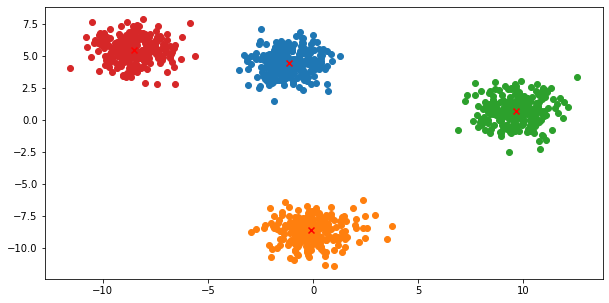

In [35]:
k = 4

X, _ = make_blobs(n_samples=1000, n_features=2, centers=k)

centroids = perform_k_means_algorithm(X, k, movement_threshold_delta=1/10, distance_mesuring_method=get_euclidean_distance)

clusters = get_clusters(X, centroids, get_euclidean_distance)

plt.rcParams['figure.figsize'] = [10, 5]
for centroid, points in clusters.items():
    points = np.array(points)
    centroid = np.mean(points, axis=0)


    plt.scatter(points[:, 0], points[:, 1], marker='o')
    plt.grid()
    plt.scatter(centroid[0], centroid[1], marker='x', color="red")

plt.show()

# **Decision Tree From Scratch**

In [87]:
import numpy
import pandas
import random
import time

In [88]:
def trainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

def checkPurity(data):
    if len(numpy.unique(data[:, -1])) == 1:
        return True
    else:
        return False

def classifyData(data):
    uniqueClasses, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    return uniqueClasses[uniqueClassesCounts.argmax()]

def getPotentialSplits(data, randomAttributes):
    potentialSplits = {}
    _, columns = data.shape
    columnsIndices = list(range(columns - 1))
    if randomAttributes != None  and len(randomAttributes) <= len(columnsIndices):
        columnsIndices = randomAttributes
    for column in columnsIndices:
        values = data[:, column]
        uniqueValues = numpy.unique(values)
        if len(uniqueValues) == 1:
            potentialSplits[column] = uniqueValues
        else:
            potentialSplits[column] = []
            for i in range(len(uniqueValues)):
                if i != 0:
                    currentValue = uniqueValues[i]
                    previousValue = uniqueValues[i - 1]
                    potentialSplits[column].append((currentValue + previousValue) / 2)
    return potentialSplits

def splitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]

def calculateEntropy(data):
    _, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -numpy.log2(probabilities))

def calculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * calculateEntropy(dataBelow) + pDataAbove * calculateEntropy(dataAbove)

def determineBestSplit(data, potentialSplits, randomSplits = None):
    overallEntropy = 9999
    bestSplitColumn = 0
    bestSplitValue = 0
    if randomSplits == None:
        for splitColumn in potentialSplits:
            for splitValue in potentialSplits[splitColumn]:
                dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
                currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
                if currentOverallEntropy <= overallEntropy:
                    overallEntropy = currentOverallEntropy
                    bestSplitColumn = splitColumn
                    bestSplitValue = splitValue
    else:
        for i in range(randomSplits):
            randomSplitColumn = random.choice(list(potentialSplits))
            randomSplitValue = random.choice(potentialSplits[randomSplitColumn])
            dataBelow, dataAbove = splitData(data, randomSplitColumn, randomSplitValue)
            currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
            if currentOverallEntropy <= overallEntropy:
                overallEntropy = currentOverallEntropy
                bestSplitColumn = randomSplitColumn
                bestSplitValue = randomSplitValue
    return bestSplitColumn, bestSplitValue

def buildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
    if checkPurity(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return classifyData(data)
    else:
        currentDepth += 1
        potentialSplits = getPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = determineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return classifyData(data)
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer = buildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            noAnswer = buildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree

def classifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return classifySample(sample, answer)

def decisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(classifySample, axis = 1, args = (decisionTree,))
    return predictions

def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

In [90]:
#from decisionTree import trainTestSplit, buildDecisionTree, decisionTreePredictions, calculateAccuracy

dataFrame = pandas.read_csv("/content/car_evaluation.csv")

buyingMapping = {"low": 1, "med": 2, "high": 3, "vhigh": 4}
dataFrame["buying"] = dataFrame["buying"].map(buyingMapping)

maintMapping = {"low": 1, "med": 2, "high": 3, "vhigh": 4}
dataFrame["maint"] = dataFrame["maint"].map(maintMapping)

doorsMapping = {"2": 2, "3": 3, "4": 4, "5more": 5}
dataFrame["doors"] = dataFrame["doors"].map(doorsMapping)

personsMapping = {"2": 2, "4": 4, "more": 6}
dataFrame["persons"] = dataFrame["persons"].map(personsMapping)

lugBootMapping = {"small": 1, "med": 2, "big": 3}
dataFrame["lug_boot"] = dataFrame["lug_boot"].map(lugBootMapping)

safetyMapping = {"low": 1, "med": 2, "high": 3}
dataFrame["safety"] = dataFrame["safety"].map(safetyMapping)

dataFrameTrain, dataFrameTest = trainTestSplit(dataFrame, testSize = 0.3)

print("Decision Tree - Car Evaluation Dataset")

i = 1
accuracyTrain = 0
while accuracyTrain < 100:
    startTime = time.time()
    decisionTree = buildDecisionTree(dataFrameTrain, maxDepth = i)
    buildingTime = time.time() - startTime
    decisionTreeTestResults = decisionTreePredictions(dataFrameTest, decisionTree)
    accuracyTest = calculateAccuracy(decisionTreeTestResults, dataFrameTest.iloc[:, -1]) * 100
    decisionTreeTrainResults = decisionTreePredictions(dataFrameTrain, decisionTree)
    accuracyTrain = calculateAccuracy(decisionTreeTrainResults, dataFrameTrain.iloc[:, -1]) * 100
    print("maxDepth = {}: ".format(i), end = "")
    print("accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")
    i += 1

Decision Tree - Car Evaluation Dataset
maxDepth = 1: accTest = 71.04%, accTrain = 69.59%, buildTime = 0.02s
maxDepth = 2: accTest = 77.80%, accTrain = 77.77%, buildTime = 0.02s
maxDepth = 3: accTest = 80.12%, accTrain = 78.76%, buildTime = 0.03s
maxDepth = 4: accTest = 81.85%, accTrain = 84.46%, buildTime = 0.04s
maxDepth = 5: accTest = 84.56%, accTrain = 87.44%, buildTime = 0.04s
maxDepth = 6: accTest = 87.64%, accTrain = 91.65%, buildTime = 0.05s
maxDepth = 7: accTest = 89.77%, accTrain = 94.05%, buildTime = 0.07s
maxDepth = 8: accTest = 94.98%, accTrain = 96.86%, buildTime = 0.08s
maxDepth = 9: accTest = 94.59%, accTrain = 98.51%, buildTime = 0.10s
maxDepth = 10: accTest = 98.07%, accTrain = 99.42%, buildTime = 0.10s
maxDepth = 11: accTest = 97.68%, accTrain = 99.83%, buildTime = 0.12s
maxDepth = 12: accTest = 97.68%, accTrain = 100.00%, buildTime = 0.12s


# **Gradient Boosting From Scratch**

In [94]:
%matplotlib inline

import pandas as pd
import numpy as np
from fastai.imports import *
from IPython.display import display
from sklearn import metrics

In [95]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [96]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

Data simulation

In [97]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [111]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(15,10,10)
y2 = np.random.uniform(25,18,10)
y3 = np.random.uniform(0,2,10)
y4 = np.random.uniform(25,30,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

Scatter plot of data

In [99]:
x.shape, y.shape

((50, 1), (50, 1))

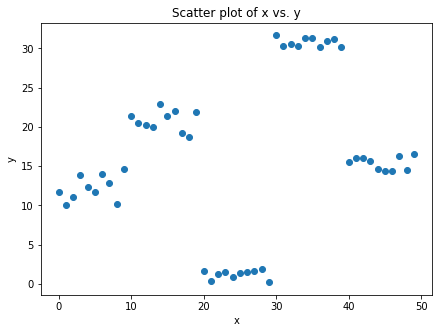

In [110]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Gradient Boosting (DecisionTrees in a loop)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

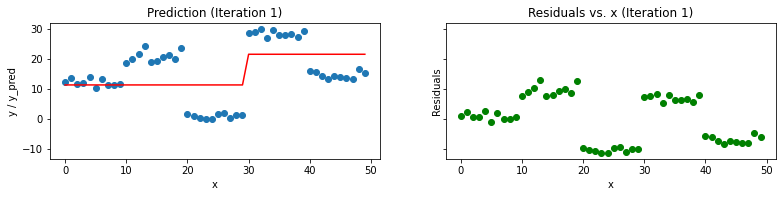

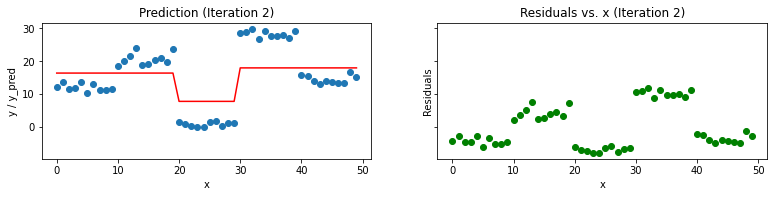

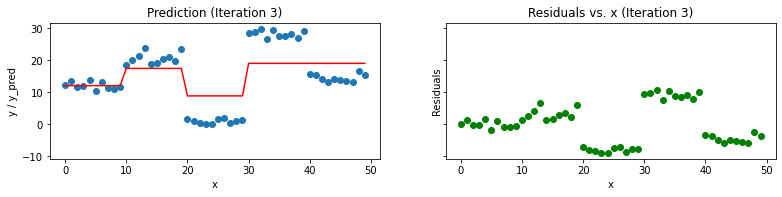

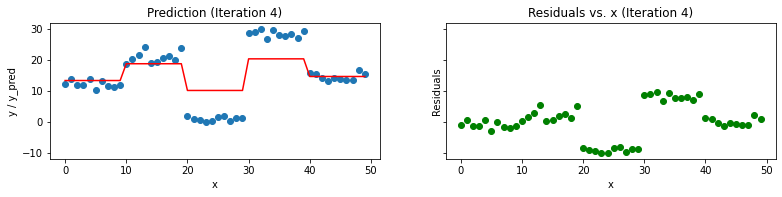

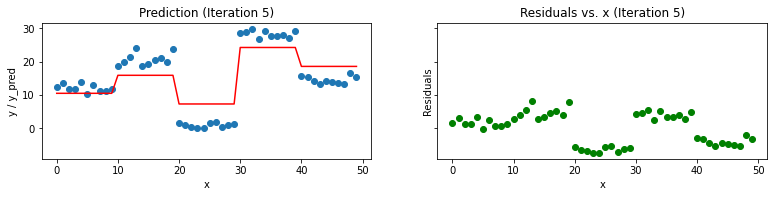

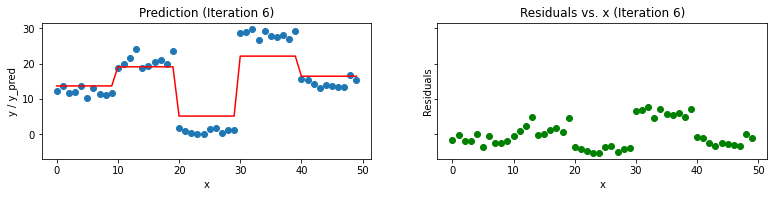

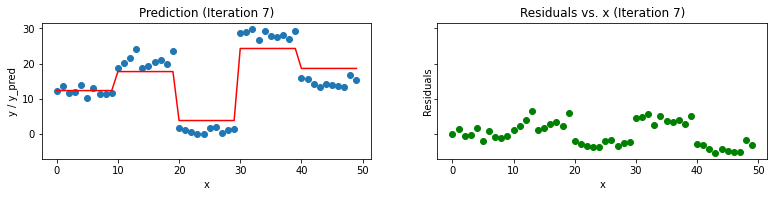

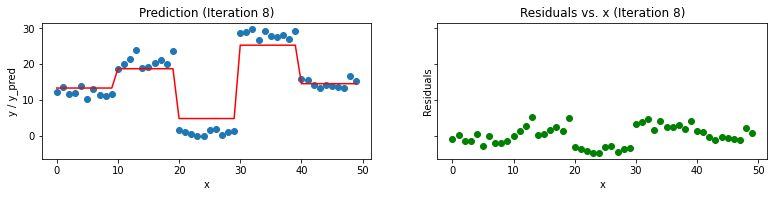

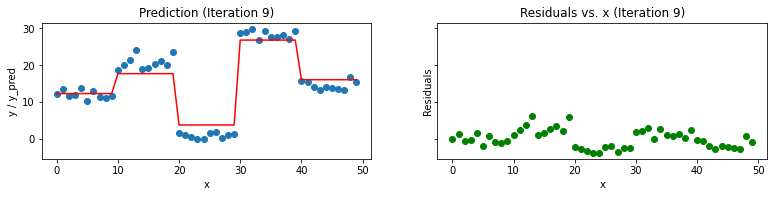

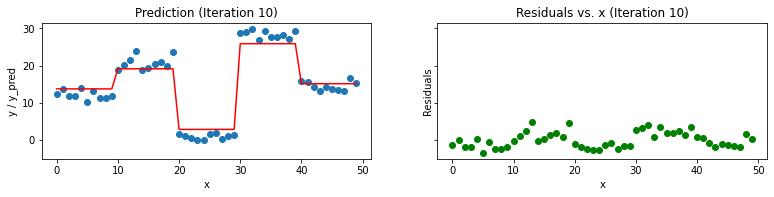

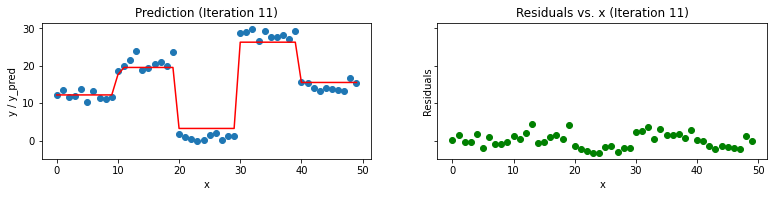

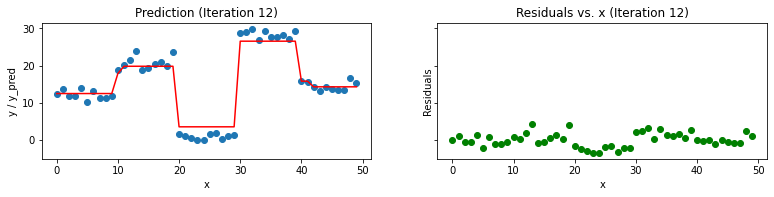

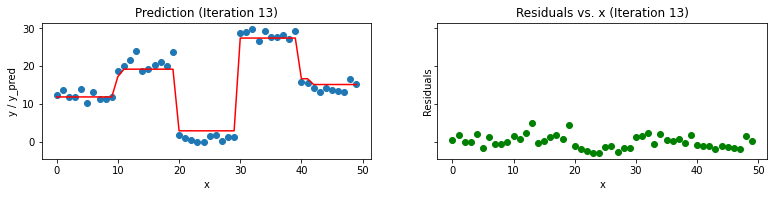

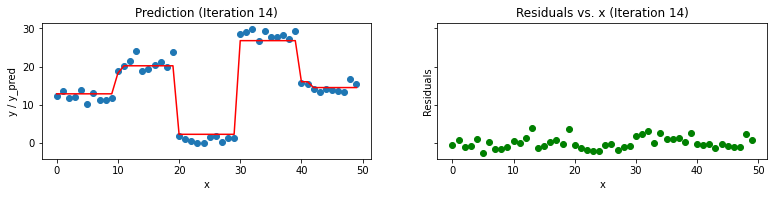

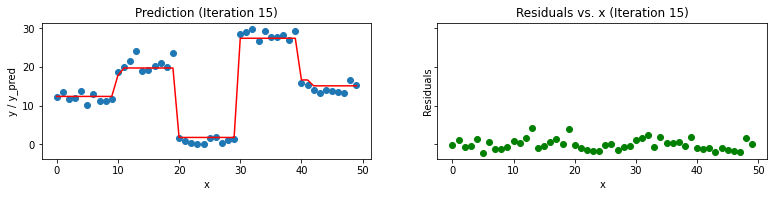

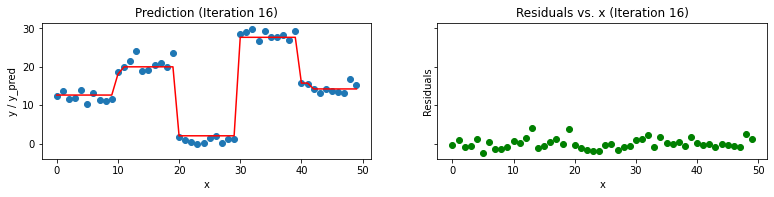

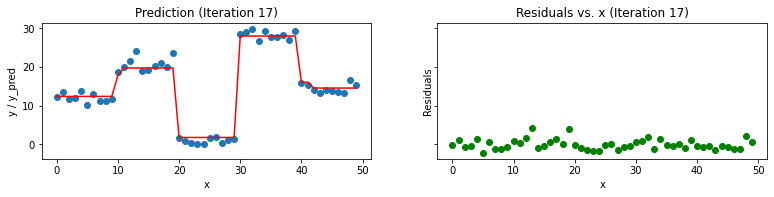

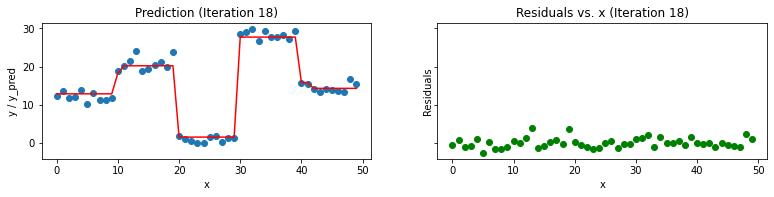

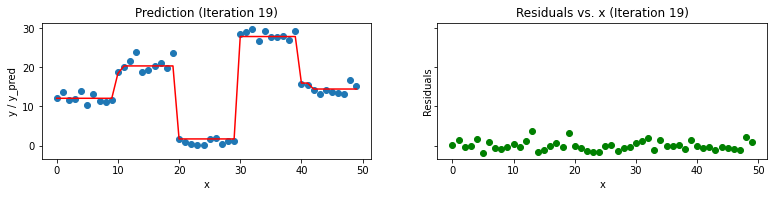

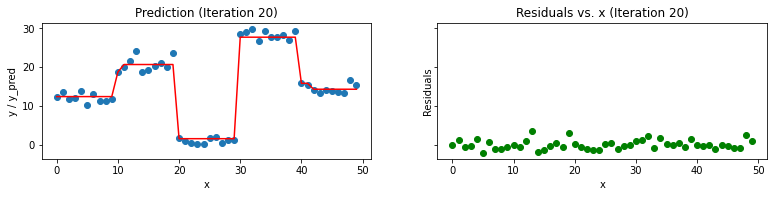

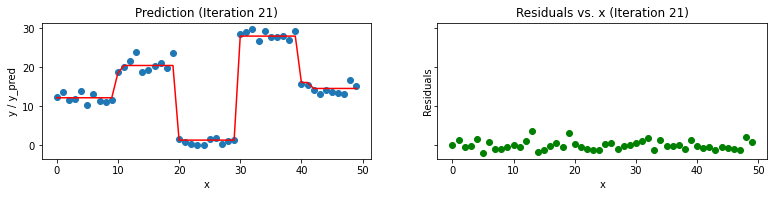

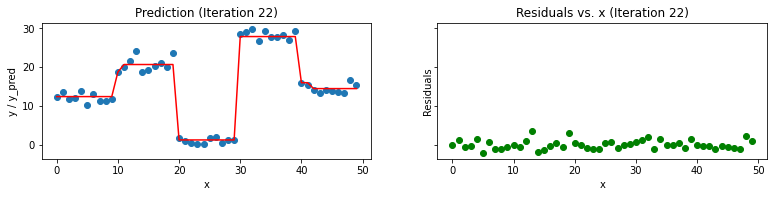

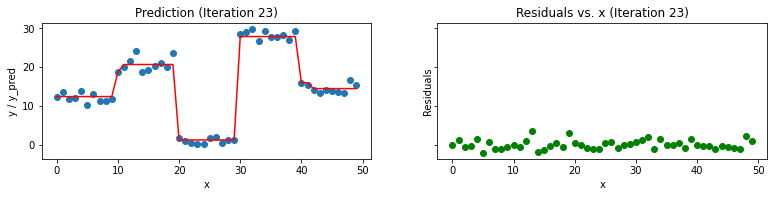

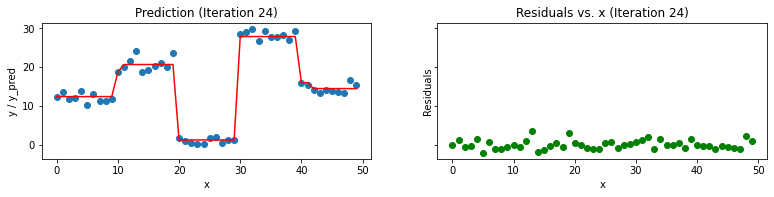

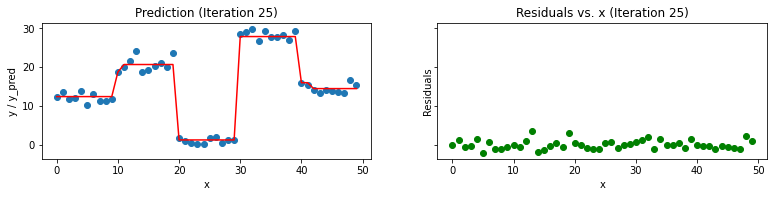

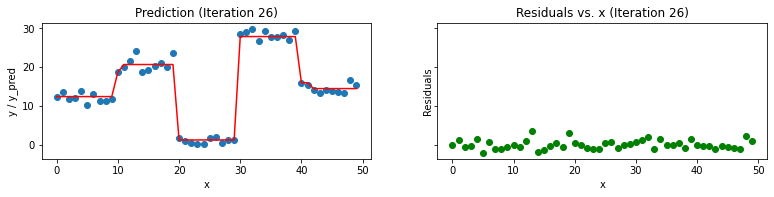

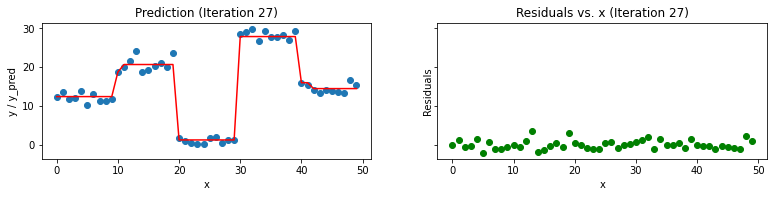

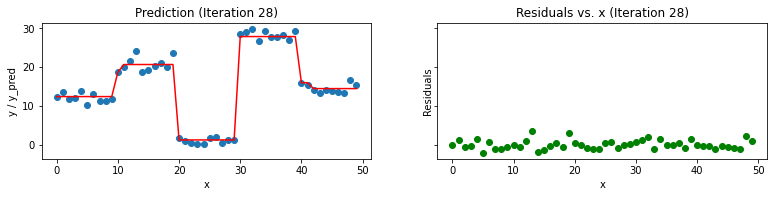

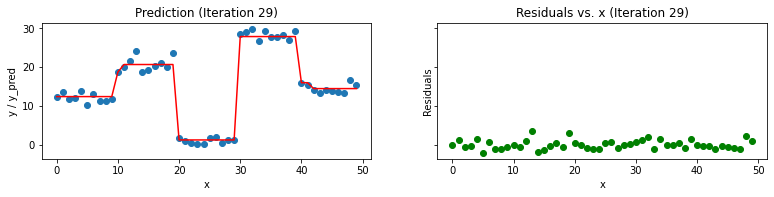

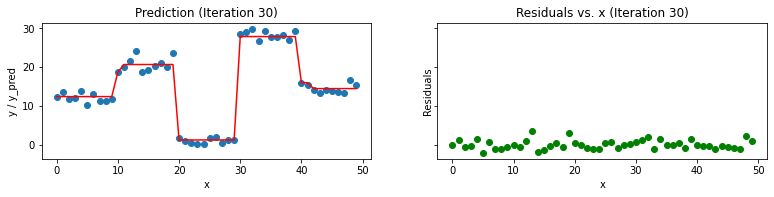

In [112]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # loop will make 30 trees (n_estimators). 
    tree = DecisionTree(xi,yi) # DecisionTree scratch code can be found in shared github/kaggle link. 
                               # It just create a single decision tree with provided min. sample leaf
    tree.find_better_split(0)  # For selected input variable, this splits (<n and >n) data so that std. deviation of 
                               # target variable in both splits is minimum as compared to all other splits
    
    r = np.where(xi == tree.split)[0][0]   #  finds index where this best split occurs
    
    left_idx = np.where(xi <= tree.split)[0] # index lhs of split
    right_idx = np.where(xi > tree.split)[0] # index rhs of split
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    

Errors are not changing much after 20th iteration and pattern in residuals is also removed. Residuals look distributed around the mean

# **Adaboost Algorithm From Scratch**

In [113]:
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

In [114]:
from sklearn.base import BaseEstimator


class Logistic_Regression(BaseEstimator):
    
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.cost_per_iteration = []
        
    
    def _sigmoid(self, x):
        EPS = 1e-7
        return 1 / (1 + np.exp(-x + EPS))
    
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        
        # gradient descent

        for _ in range(self.epochs):
            # forward propagation
            Z = np.dot(X, self.weights) + self.bias
            A = self._sigmoid(Z)
            
            # backward propagation
            dw = (1 / m) * np.dot(X.T, A - y)
            db = (1 / m) * np.sum(A - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        Z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(Z)
    
        if not isinstance(A, float):
            y_predicted_cls = [1 if i >= 0.5 else 0 for i in A]
        else:
            y_predicted_cls = 1 if A >= 0.5 else 0
        return y_predicted_cls
    
    
    def __str__(self):
        return f"Logistic_Regression(learning_rate={self.learning_rate}, epochs={self.epochs})"

In [115]:
class AdaBoost(object):
    
    def __init__(self, base_estimator, n_estimators, learning_rate):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.predictor_weightages = []
        
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        for i in range(self.n_estimators):

            # initially all instances have the same weight
            instance_weights = self._initial_instance_weights(n_samples)
            
            # Use predictor to make classification error
            clone_clf = clone(self.base_estimator)
            clone_clf.fit(X, y)
            predicted = clone_clf.predict(X)
            
            # getting misclassified instances
            mis_classified_instances, acc = self._getAccuracy(y, predicted)
            
            # total error made by the predictor
            total_err = self._total_error(mis_classified_instances, instance_weights)
            
            # weightage of predictor based on its error
            predictor_weightage = self._get_predictor_weightage(total_err)
            self.predictor_weightages.append((i, clone_clf, predictor_weightage))
            
            # updating instance weights
            instance_weights = self._update_instance_weights(mis_classified_instances, 
                                                             instance_weights, predictor_weightage)

            
            # sampling data with replacement focusing on instances that were misclassified
            X, y = self._new_sample_set(X, y, instance_weights)

    

    def _initial_instance_weights(self, shape):
        instance_weights = np.full(shape=shape, fill_value=1/shape)
        return instance_weights
    
    
    def _getAccuracy(self, true, predicted):
        assert len(true) == len(predicted)
        error_instance = np.equal(true, predicted).astype(int)
        miss_classified = []

        for i, j in enumerate(error_instance):
            if j == 0:
                miss_classified.append(i)
                
        accuracy = np.sum(true == predicted)
        return miss_classified, (accuracy/len(true)) * 100.0
    
    
    def _total_error(self, mis_classified, instance_weights):
        error = 0
        for i in mis_classified:
            error += instance_weights[i]

        return error
    
    def _get_predictor_weightage(self, error):
        EPS = 1e-5
        weightage = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))
        return weightage

    
    def _update_instance_weights(self, mis_classified_instances, instance_weights, predictor_weightage):
        weights = instance_weights[:]
        EPS = 1e-10
        for idx in range(len(instance_weights)):
            if idx in mis_classified_instances:
                weights[idx] = weights[idx] * np.exp(predictor_weightage + EPS)
            else:
                weights[idx] = weights[idx] * np.exp(-predictor_weightage + EPS)


        summed_weights = np.sum(weights)
        weights /= summed_weights
        return np.array(weights)
    
    def _new_sample_set(self, X, y, instance_weights):
        intervals = []
        intervals.append(instance_weights[0])

        for i, j in enumerate(instance_weights[1:], 1):
            intervals.append(j + intervals[i-1])

        idxs = []

        for i in range(X.shape[0]):
            samp = np.random.sample()
            try:
                idx = np.searchsorted(intervals, samp, side='right')
                _ = X[idx] # check if exists
            except:
                idx = idx - 1

            finally:
                idxs.append(idx)

        X = X[idxs]
        y = y[idxs]
        return X, y
    
    def predict(self, X):
        clf_predictions = np.array([clf.predict(X) for idx, clf, weightage in self.predictor_weightages])
        predictions = []
        
        for sample_predictions in clf_predictions.T:
            class_0 = 0
            class_1 = 0
            
            for predictor, predictor_op in enumerate(sample_predictions):
                if predictor_op == 0:
                    class_0 += self.predictor_weightages[predictor][2]
                else:
                    class_1 += self.predictor_weightages[predictor][2]
            
            if class_0 > class_1:
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)

In [116]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [117]:
breast_cancer = load_breast_cancer()

In [118]:
breast_cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [119]:
import pandas as pd
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['target'] = breast_cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [120]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [127]:
ada_clf = AdaBoost(base_estimator=Logistic_Regression(learning_rate=0.001, epochs=500),
                  n_estimators=10, learning_rate=0.5)

In [128]:
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_train)
print(f"Training Accuracy: {round(accuracy(y_train, y_pred), 2)}")

y_pred = ada_clf.predict(X_test)
print(f"Validation Accuracy: {round(accuracy(y_test, y_pred), 2)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Training Accuracy: 0.92
Validation Accuracy: 0.92


In [129]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [130]:
print(f"Model Precision: {precision_score(y_test, y_pred)}")
print(f"Model Recall: {recall_score(y_test, y_pred)}")
print(f"Model F1-score: {f1_score(y_test, y_pred)}")

Model Precision: 0.92
Model Recall: 0.9583333333333334
Model F1-score: 0.9387755102040817


In [131]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholdsh = roc_curve(y_test, y_pred)

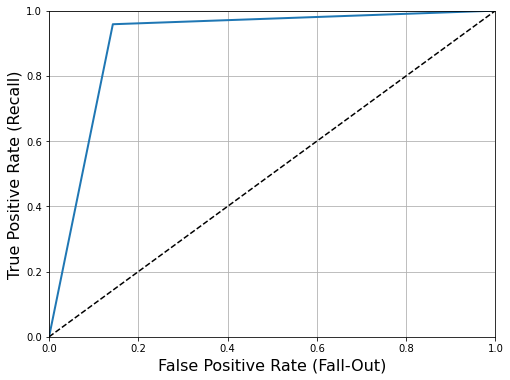

In [132]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

In [133]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.9077380952380953

# **Random Forest From Scratch**

In [134]:
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import pandas as pd

from collections import Counter
from sklearn import tree

In [135]:
from sklearn.tree import DecisionTreeClassifier

In [136]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [137]:
class RandomForest:

    def __init__(self, n_trees=10, min_samples_split=2,
                 max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth, max_features=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [138]:
rnd_clf = RandomForest(max_depth=10, n_trees=10, n_feats=6)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

In [139]:
print(f"Accuracy: {accuracy(y_test, y_pred)}")

Accuracy: 0.9385964912280702


In [140]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

Precision: 0.9333333333333333
Recall: 0.9722222222222222
F1-Score: 0.9523809523809524


# **Aprior From Scratch**

In [145]:
from collections import Counter
from itertools import combinations
import numpy as np

In [150]:
transactions = {
    1: ["5", "4", "3"],
    2: ["2", "3", "4"],
    3: ["1", "2", "5", "3"],
    5: ["2", "5"],
    6: ["1", "3", "5"]
}

min_support_count = 2
min_confidence_value = 0.6


In [151]:
def _pruning(current, previous, size):
    final_keys = []
    previous = [tuple(i) for i in previous]
    for key in current:
        FLAG = False
        current_comb = list(combinations(key, size))
        for i in current_comb:
            if i in previous or i[::-1] in previous:
                FLAG = True
            else:
                FLAG = False
                break

        if FLAG:
            final_keys.append(key)

    return final_keys


def support_value(itemset_keys_, transactions):
    itemset = {key: 0 for key in itemset_keys_}

    for keys in itemset_keys_:
        for val in transactions.values():
            if set(keys) & set(val) == set(keys):
                itemset[keys] += 1
    return itemset


# creating frequent itemset
def get_frequent_itemset(size=None, transactions=None, itemset=None):
    if size == 1:
        itemset = Counter()

        for val in transactions.values():
            itemset.update(val)

    else:

        prev_itemset_keys = list(itemset.keys())
        prev_itemset = itemset.copy()

        valid_keys = list(set(itemset.keys()))
        l = []
        for row in valid_keys:
            l.extend(row)

        valid_keys = set(l)

        # candidate itemset keys
        itemset_keys_ = list(combinations(valid_keys, size))

        if size >= 2:
            itemset_keys_ = _pruning(
                itemset_keys_, prev_itemset_keys, size - 1)

        itemset = support_value(itemset_keys_, transactions)

        if itemset == {}:
            itemset = prev_itemset

    frequent_itemset = {}
    for key, val in itemset.items():
        if val >= min_support_count:
            frequent_itemset[key] = val

    return frequent_itemset


def finding_subsets(frequent_set):
    item_list = []
    size = len(list(frequent_set.keys())[0])
    for key in frequent_set.keys():
        subsets = []
        for i in range(1, size):
            subsets.append(list(combinations(key, i)))

        subsets = list(np.array(subsets).flatten())
        subsets.insert(0, key)
        item_list.append(subsets)

    return item_list


def finding_rules(itemset_sub):
    print("Antecedents -->  Consequents --- Confidence")
    for i in range(1, len(itemset_sub)):

        x = support_value([itemset_sub[0], ], transactions)
        y = support_value([itemset_sub[i], ], transactions)
        confidence = list(x.values())[0] / list(y.values())[0]
        if confidence >= min_confidence_value:
            print(
                f"{itemset_sub[i]} --> {itemset_sub[0]} --- {round(confidence, 2)}")



In [152]:

print("""
    ITEMS
    1: Cake1
    2: Cake2
    3: Cake3
    4: Cake4
    5: Cake5
""")

f = {}

for i in range(1, 4):
    f = get_frequent_itemset(size=i, transactions=transactions,
                             itemset=f)

# frequent_itemsets

print("Frequent Itemsets...")
for key, val in f.items():
    print(f"Itemset: {key}, support value: {val}")


subset = finding_subsets(f)

for i in subset:
    print(f"Rules for itemset - {i[0]}")
    finding_rules(i)
    print()


    ITEMS
    1: Cake1
    2: Cake2
    3: Cake3
    4: Cake4
    5: Cake5

Frequent Itemsets...
Itemset: ('1', '3', '5'), support value: 2
Rules for itemset - ('1', '3', '5')
Antecedents -->  Consequents --- Confidence
('1',) --> ('1', '3', '5') --- 1.0
('1', '3') --> ('1', '3', '5') --- 1.0
('1', '5') --> ('1', '3', '5') --- 1.0
('3', '5') --> ('1', '3', '5') --- 0.67



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **FPgrowth Algorithm From Scratch**

In [153]:
from collections import defaultdict, namedtuple
import itertools
from itertools import  *

In [154]:
def find_frequent_itemsets(transactions, minimum_support, include_support=False):

    items = defaultdict(lambda: 0)

    for transaction in transactions:
        for item in transaction:
            items[item] += 1

    items = dict((item, support) for item, support in items.items()
        if support >= minimum_support)

    def clean_transaction(transaction):
        transaction = list(filter(lambda v: v in items, transaction))
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, transactions):
        master.add(transaction)

    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = sum(n.count for n in nodes)
            if support >= minimum_support and item not in suffix:
                found_set = [item] + suffix
                yield (found_set, support) if include_support else found_set


                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item))
                for s in find_with_suffix(cond_tree, found_set):
                    yield s 

    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.
    This object may only store transaction items that are hashable
    (i.e., all items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        self._root = FPNode(self, None, None)
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """Add a transaction to the tree."""
        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                next_point.increment()
            else:
                next_point = FPNode(self, item)
                point.add(next_point)
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

    def nodes(self, item):
        """
        Generate the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generate the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print('Tree:')
        self.root.inspect(1)

        print
        print('Routes:')
        for item, nodes in self.items():
            print('  %r') % item
            for node in nodes:
                print('    %r') % node

def conditional_tree_from_paths(paths):
    """Build a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Add the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Check whether this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """
        try:
            return self._children[item]
        except KeyError:
            return None

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increment the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    @property
    def parent(self):
        """The node's parent"""
        return self._parent

    @parent.setter
    def parent(self, value):
        if value is not None and not isinstance(value, FPNode):
            raise TypeError("A node must have an FPNode as a parent.")
        if value and value.tree is not self.tree:
            raise ValueError("Cannot have a parent from another tree.")
        self._parent = value

    @property
    def neighbor(self):
        """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        return self._neighbor

    @neighbor.setter
    def neighbor(self, value):
        if value is not None and not isinstance(value, FPNode):
            raise TypeError("A node must have an FPNode as a neighbor.")
        if value and value.tree is not self.tree:
            raise ValueError("Cannot have a neighbor from another tree.")
        self._neighbor = value

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())

    def inspect(self, depth=0):
        print ('  ' * depth) + repr(self)
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)


In [155]:
minsup=4
test_data = [['1','2','5'],
             ['2','4'],
             ['2','3'],
             ['1','2','4'],
             ['1','3'],
             ['2','3'],
             ['1','3'],
             ['1','2','3','5'],
             ['1','2','3']]

result = []
for itemset, support in find_frequent_itemsets(test_data, minsup, True):
  result.append((itemset,support))



In [156]:
result = sorted(result, key=lambda i: i[0])
for itemset, support in result:
  print (str(itemset) + ' ' + str(support))

['1'] 6
['1', '3'] 4
['2'] 7
['2', '1'] 4
['2', '3'] 4
['3'] 6
